# 4 2-D Anisotropic Diffusion

In this tutorial, we consider the following anisotropic diffusion problem

$$
	a(v, u) = \int_{\Omega}  \frac{\kappa_{\parallel}}{\|\mathbf{B}\|^2} (\textbf{B} \cdot \nabla v) (\textbf{B} \cdot \nabla u) + \kappa_{I} \nabla v \cdot \nabla u d\Omega, \quad \forall u,v \in \mathcal{V}_h
$$

where $\textbf{B}$ denotes the magnetic field, $\Omega$ is our 2D computational domain and $\mathcal{V}_h \subset H^1(\Omega)$. 
We are interested in highly anisotropic configurations with $\displaystyle \frac{\kappa_{\parallel}}{\kappa_{I}} \simeq 10^6 \gg 1$.

In [1]:
from numpy import linspace, meshgrid, pi

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Math

from sympy.core.containers import Tuple
from sympy import symbols
from sympy import Symbol
from sympy import Lambda
from sympy import IndexedBase

from gelato.glt import glt_symbol
from gelato.glt import glt_lambdify
from gelato.glt import glt_approximate_eigenvalues
from gelato.calculus   import (Dot, Cross, Grad, Curl, Rot, Div)
from gelato.fem.assembly import assemble_matrix
from gelato.fem.utils    import compile_kernel

from spl.fem.splines import SplineSpace
from spl.fem.tensor  import TensorSpace

In [2]:
x,y = symbols('x y')

u = Symbol('u')
v = Symbol('v')

k_par = Symbol('k_par')
k_perp = Symbol('k_perp')

b1 = Symbol('b1')
b2 = Symbol('b2')
b = Tuple(b1, b2)

a = Lambda((x,y,v,u), k_perp * Dot(Grad(v), Grad(u)) + k_par * Dot(b, Grad(v)) * Dot(b, Grad(u)))


In [3]:
# ...  create a finite element space
p1  = 3 ; p2  = 3
ne1 = 16 ; ne2 = 16

grid_1 = linspace(0., 1., ne1+1)
grid_2 = linspace(0., 1., ne2+1)

V1 = SplineSpace(p1, grid=grid_1)
V2 = SplineSpace(p2, grid=grid_2)

V = TensorSpace(V1, V2)
# ...

In [4]:
d_constants = {'b2': 1., 'k_perp': 1.}
d_types = {'b1': 'double', 'k_par': 'double'}

In [5]:
kernel_f90 = compile_kernel('kernel_2', a, V,
                            d_constants=d_constants,
                            d_args=d_types,
                            backend='fortran')


In [6]:
d_args = {'b1': 1.165939762441386085001227002067, 
          'k_par': 1.e4}

In [7]:
M = assemble_matrix(V, kernel_f90, args=d_args).tocsr()

In [8]:
# import eigenvalue solver
from scipy.linalg import eig

M = M.todense()
w, v = eig(M)
wr = w.real
wr.sort()

In [9]:
symbol = glt_symbol(a, space=V, evaluate=True)

In [10]:
# ... lambdify the glt symbol
# TODO improve
symbol = symbol.subs(d_constants)
symbol = symbol.subs(d_args)
# ...

In [11]:
eig = glt_approximate_eigenvalues(symbol, space=V)
t = eig
t.sort()

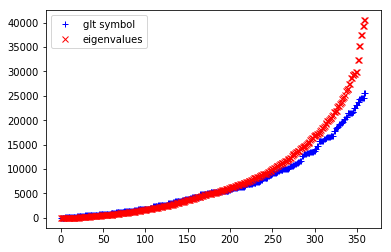

In [12]:
plt.plot(t, "+b", label="glt symbol")
plt.plot(wr, "xr", label="eigenvalues")
plt.legend(loc=2);

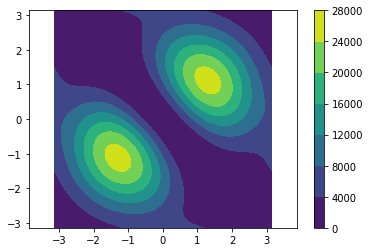

In [13]:
# ... lambdify the symbol
F = glt_lambdify(symbol)
# ...

# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

t1, t2 = meshgrid(t1, t2)
x, y = meshgrid(x, y)

f = F(x,y,t1,t2)
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

Let's now create the symbol for linear B-Splines

In [14]:
# ...  create a finite element space
W1 = SplineSpace(degree=1, grid=grid_1)
W2 = SplineSpace(degree=1, grid=grid_2)

W = TensorSpace(W1, W2)
# ...

symbol_1 = glt_symbol(a, space=W, evaluate=True)

# ... lambdify the glt symbol
# TODO improve
symbol_1 = symbol_1.subs(d_constants)
symbol_1 = symbol_1.subs(d_args)
# ...

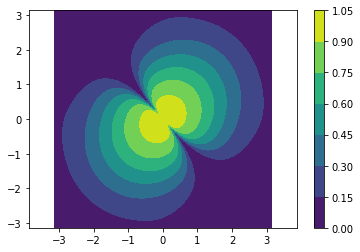

In [15]:
# ... lambdify the symbol
F_p = glt_lambdify(symbol)
F_1 = glt_lambdify(symbol_1)
# ...

# ... compute the symbol f_a / f_c
nx = 100 ; ny = 100
t1 = linspace(-pi,pi, nx)
t2 = linspace(-pi,pi, ny)

x = linspace(0.,1.,nx)
y = linspace(0.,1.,ny)

t1, t2 = meshgrid(t1, t2)
x, y = meshgrid(x, y)

f = F_p(x,y,t1,t2) / F_1(x,y,t1,t2)
# ...

# ... plot
plt.contourf(t1, t2, f)
plt.axis("equal")
plt.colorbar();
# ...

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()